In [1]:
import os


os.environ["KERAS_BACKEND"] = "torch"


import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout, Normalization, Input
from keras.models import Sequential
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("../../.data/lowhigh_2023_2025.csv")
del df["Unnamed: 0"]
df = df[df["low"] != "NOT AVAILABLE"]
df = df.dropna()
df

,date,market,commodity,low,high
0,2024-01-02,Taguig People's Market,sugar (washed),75.0,80.0
1,2024-01-02,Dagonoy Market,pechay baguio,80.0,90.0
2,2024-01-02,Marikina Public Market,well-milled rice (local),48.00,48.00
3,2024-01-02,Guadalupe Public Market/Makati,tilapia,140.0,150.0
4,2024-01-02,Guadalupe Public Market/Makati,corn (yellow),60.00,80.00
...,...,...,...,...,...
151828,2025-02-25,Kamuning Public Market,cabbage,70.0,90.0
151829,2025-02-25,Kamuning Public Market,tomato,40.0,60.0
151830,2025-02-25,Kamuning Public Market,eggplant,90.0,100.0
151831,2025-02-25,Muñoz Market/Quezon City,cabbage,50.0,120.0


In [3]:
set(df["market"])

{'Agora Public Market/San Juan',
 'Balintawak (Cloverleaf) Market',
 'Bicutan Market',
 'Blumentritt Market',
 'Cartimar Market',
 'Commonwealth Market/Quezon City',
 'Dagonoy Market',
 'Guadalupe Public Market/Makati',
 'Kamuning Public Market',
 'La Huerta Market/Parañaque',
 'Malabon Central Market',
 'Mandaluyong Public Market',
 'Marikina Public Market',
 'Maypajo Public Market/Caloocan',
 'Mega Q-mart/Quezon City',
 'Murphy Public Market',
 'Muñoz Market/Quezon City',
 'Muñoz Market/Quezon City\nNavotas Agora Market',
 'Navotas Agora Market',
 'New Las Piñas City Public Market',
 'New Marulas Public Market/Valenzuela',
 'Obrero Market',
 'Paco Market',
 'Pamilihang Lungsod ng Muntinlupa',
 'Pasay City Market',
 'Pasig City Mega Market',
 'Pateros Market',
 'Pritil Market/Manila',
 'Quinta Market/Manila',
 'San Andres Market/Manila',
 "Taguig People's Market",
 'Trabajo Market'}

In [4]:
data_by_commodities = {}

for commodity in set(df["commodity"]):
    # print("[INFO] processing:", commodity)
    data_by_commodities[commodity] = df.loc[df["commodity"] == commodity]

data_by_commodities

{'galunggong':               date                           market   commodity     low  \
 34      2024-01-02           Kamuning Public Market  galunggong  240.00   
 70      2024-01-02     Agora Public Market/San Juan  galunggong  300.00   
 82      2024-01-02                  Cartimar Market  galunggong  280.00   
 112     2024-01-02           Marikina Public Market  galunggong  240.00   
 134     2024-01-02          Mega Q-mart/Quezon City  galunggong  220.00   
 ...            ...                              ...         ...     ...   
 145950  2025-02-06           Pasig City Mega Market  galunggong  280.00   
 146047  2025-02-06  Commonwealth Market/Quezon City  galunggong  260.00   
 146049  2025-02-06                  Cartimar Market  galunggong  260.00   
 146056  2025-02-06               Blumentritt Market  galunggong  350.00   
 146061  2025-02-06     Agora Public Market/San Juan  galunggong  340.00   
 
           high  
 34      280.00  
 70      320.00  
 82      300.00  


,date,market,commodity,low,high
1506,2024-01-10,Pateros Market,cabbage (scorpio),70.00,80.00
1850,2024-01-11,Pateros Market,cabbage (scorpio),70.00,80.00
2182,2024-01-12,Pateros Market,cabbage (scorpio),70.00,80.00
2666,2024-01-15,Pateros Market,cabbage (scorpio),70.00,80.00
3028,2024-01-16,Pateros Market,cabbage (scorpio),70.00,80.00
...,...,...,...,...,...
144082,2025-02-01,Pateros Market,cabbage (scorpio),80.00,100.00
144466,2025-02-03,Pateros Market,cabbage (scorpio),80.00,100.00
145108,2025-02-04,Pateros Market,cabbage (scorpio),80.00,100.00
145284,2025-02-05,Pateros Market,cabbage (scorpio),80.00,100.00


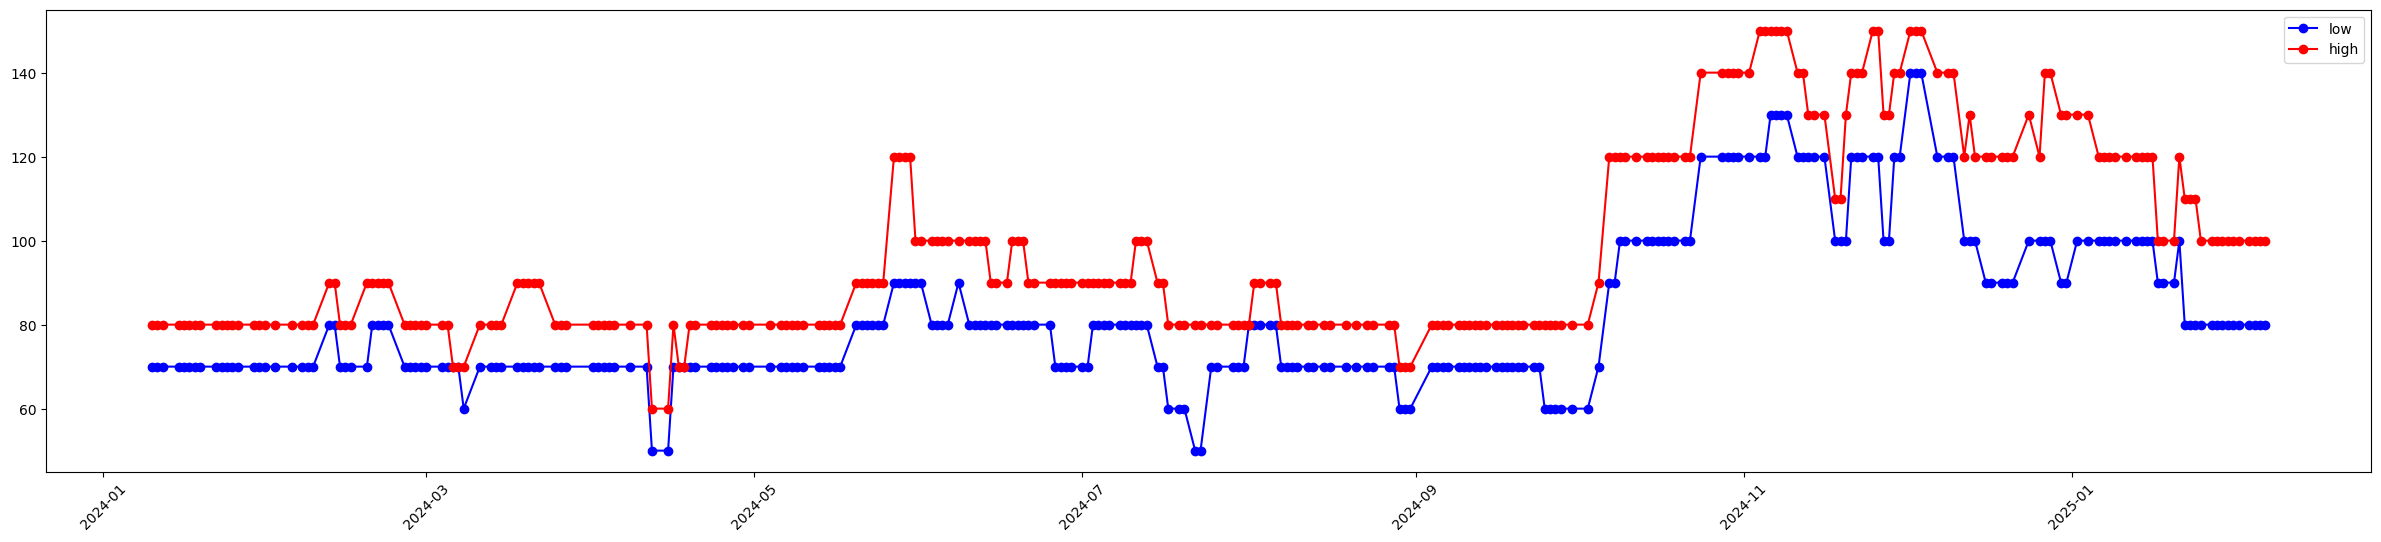

In [5]:
df_scorpio = data_by_commodities["cabbage (scorpio)"]
df_scorpio_pateros = df_scorpio[df_scorpio["market"] == "Pateros Market"]
x = pd.to_datetime(df_scorpio_pateros["date"])
low = pd.to_numeric(df_scorpio_pateros["low"])
high = pd.to_numeric(df_scorpio_pateros["high"])

plt.figure(figsize=(30, 6))
plt.xticks(rotation=45)
plt.plot(x, low, "o-b", x, high, "o-r")
plt.legend(["low", "high"])
df_scorpio_pateros

In [6]:
df_train = df_scorpio_pateros[["low", "high"]].iloc[1:]
df_train = df_train.apply(pd.to_numeric)
train_x = []
train_y = []
train_n_future = 1
train_n_past = 13

for ith in range(0, df_train.shape[0], train_n_past + train_n_future):
    tail = ith - 1 + train_n_past
    train_x.append(df_train.iloc[ith:tail].to_numpy())
    train_y.extend(df_train.iloc[tail:tail + train_n_future, 0:df_train.shape[1] - 1].to_numpy())

df_train.shape[0]

280

In [7]:
train_x = np.array(train_x)
train_y = np.array(train_y)
train_x.shape, train_y.shape

((20, 12, 2), (20, 1))

In [14]:
low_mean = np.mean([low, high])
low_var = np.var([low, high])

model = Sequential()
model.add(Input(shape=(train_x.shape[1], train_x.shape[2])))
model.add(Normalization(mean=low_mean, variance=low_var))
model.add(LSTM(128, activation="relu", return_sequences=True))
model.add(LSTM(64, activation="sigmoid", return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(train_y.shape[1]))
model.add(Normalization(mean=low_mean, variance=low_var, invert=True))

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 12, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 12, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,545 (455.25 KB)

 Trainable params: 116,545 (455.25 KB)

 Non-trainable params: 0 (0.00 B)

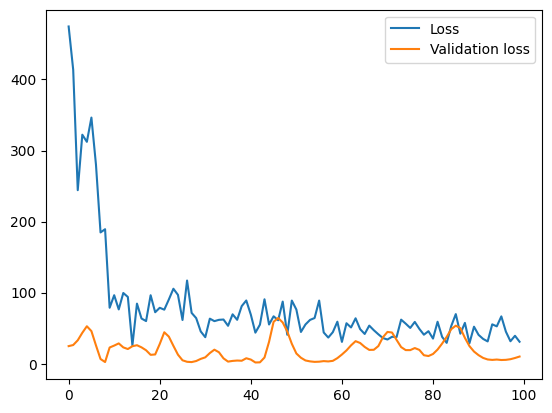

In [15]:
hist = model.fit(train_x, train_y, epochs=100, batch_size=16, validation_split=0.1, verbose=0)
plt.plot(hist.history["loss"], label="Loss")
plt.plot(hist.history["val_loss"], label="Validation loss")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


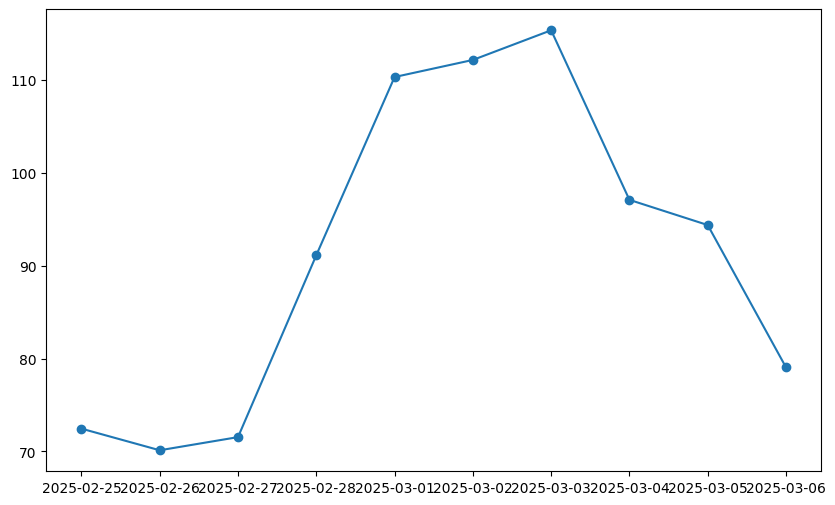

In [17]:
days_to_predict = 10
date = pd.to_datetime(df.iloc[df.shape[0] - 1]["date"])
dates = [date + pd.Timedelta(days=ith) for ith in range(days_to_predict)]
prices = model.predict(train_x[-days_to_predict:])
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, "o-")